<h1 id="title">Predicting Motor Vehicle Accident Severity in Seattle, Washington by Oversampling Minority Classes to Achieve Balanced Training Data<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7ff5a8a40310>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.680627594003454 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.53601638204418 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.68567014299333 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.36818048695568 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PEDCOUNT         171872 non-null  int64   
 3   PEDCYLCOUNT      171872 non-null  int64   
 4   VEHCOUNT         171872 non-null  int64   
 5   INJURIES         171872 non-null  int64   
 6   SERIOUSINJURIES  171872 non-null  int64   
 7   FATALITIES       171872 non-null  int64   
 8   WEATHER          171872 non-null  category
 9   ROADCOND         171872 non-null  category
 10  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(6)
memory usage: 10.0 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.724167354987003 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class_1_size =', class_1_size)
print('class_2_size =', class_2_size)
print('class_2b_size =', class_2b_size)
print('class_3_size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority_class_size =', minority_class_size)

class_1_size = 113082
class_2_size = 55521
class_2b_size = 2941
class_3_size = 328

minority_class_size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.99426532094367 seconds.


<h2 id='sample_size_class_3'>Sample all Classes Equally to Create a Balanced Training Set<\h2>

In [34]:
# This parameter determines what fraction of the minority class's data are reserved for testing.
test_size_ratio = .5

# Using train/test splits, set aside part of the data for testing.
df_class_1_train_pre_sampling, df_class_1_test = train_test_split(df_class_1, test_size=test_size_ratio, random_state=seed)
df_class_2_train_pre_sampling, df_class_2_test = train_test_split(df_class_2, test_size=test_size_ratio, random_state=seed)
df_class_2b_train_pre_sampling, df_class_2b_test = train_test_split(df_class_2b, test_size=test_size_ratio, random_state=seed)
df_class_3_train_pre_sampling, df_class_3_test = train_test_split(df_class_3, test_size=test_size_ratio, random_state=seed)

In [35]:
# Build a balanced training set by sampling the pre_sampling training data equally:

# Set a sampling parameter to control the amount of oversampling for the minority class.
# Oversampling requires this parameter to be greater than 1.
# If this parameter is less than or equal to 1, then oversampling will not occur.
sampling_ratio = 2

# Set the replace parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 3 with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_3_train = df_class_3_train_pre_sampling.sample(frac=sampling_ratio, replace=sample_with_replacement, axis='index', random_state=seed)

# Store the size of the minority class's training set.
class_3_train_size = df_class_3_train.shape[0]

# Take samples of the other classes' training data, where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in the class's training data, sample with replacement.

# Sampling for class 2b.
sample_with_replacement = bool(class_3_train_size > df_class_2b_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2b with replacement: %s' % (sample_with_replacement))
df_class_2b_train = df_class_2b_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 2.
sample_with_replacement = bool(class_3_train_size > df_class_2_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2 with replacement: %s' % (sample_with_replacement))
df_class_2_train = df_class_2_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 1.
sample_with_replacement = bool(class_3_train_size > df_class_1_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 1 with replacement: %s' % (sample_with_replacement))
df_class_1_train = df_class_1_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

Sample class 3 with replacement: True
Sample class 2b with replacement: False
Sample class 2 with replacement: False
Sample class 1 with replacement: False


In [36]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_1_train, df_class_2_train, df_class_2b_train, df_class_3_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_1_test, df_class_2_test, df_class_2b_test, df_class_3_test], axis='index')

In [37]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [38]:
# Verify the training DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b    328
2     328
1     328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_train.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312 entries, 161200 to 14369
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  1312 non-null   category
 1   PEDCOUNT       1312 non-null   int64   
 2   PEDCYLCOUNT    1312 non-null   int64   
 3   VEHCOUNT       1312 non-null   int64   
 4   WEATHER        1312 non-null   category
 5   ROADCOND       1312 non-null   category
 6   LIGHTCOND      1312 non-null   category
dtypes: category(4), int64(3)
memory usage: 47.7 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [42]:
y = df_train["SEVERITYCODE"].to_numpy()

In [43]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.346277936943807 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [44]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
#encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.2068543299101293 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0'
 'x2_1' 'x2_2' 'x3_0' 'x3_1' 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7'
 'x3_8' 'x3_9' 'x3_10' 'x3_11' 'x3_12' 'x3_13' 'x3_14' 'x3_15'
 'x4_Blowing Sand/Dirt' 'x4_Clear' 'x4_Fog/Smog/Smoke' 'x4_Other'
 'x4_Overcast' 'x4_Partly Cloudy' 'x4_Raining' 'x4_Severe Crosswind'
 'x4_Sleet/Hail/Freezing Rain' 'x4_Snowing' 'x5_Dry' 'x5_Ice' 'x5_Oil'
 'x5_Other' 'x5_Sand/Mud/Dirt' 'x5_Snow/Slush' 'x5_Standing Water'
 'x5_Wet' 'x6_Dark - No Street Lights' 'x6_Dark - Street Lights Off'
 'x6_Dark - Street Lights On' 'x6_Dark - Unknown Lighting' 'x6_Dawn'
 'x6_Daylight' 'x6_Dusk' 'x6_Other']


In [45]:
type(X)

scipy.sparse.csr.csr_matrix

In [46]:
X.shape

(1312, 62)

In [47]:
y.shape

(1312,)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 23.01305205503013 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 8.025643 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 31.23216333403252 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 0.797184 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 32.18951365002431 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10

# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_pipeline = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)

# Use only odd numbers of neighbors to avoid ties.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_weighted', cv=number_of_folds, verbose=50, pre_dispatch=2**10, error_score='raise',\
                              return_train_score=False)

grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=1024, refit='recall_weighted',
             scoring=['recall_weighted'], verbose=50)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 71.599428 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=11, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=11, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 11
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 1.186567 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 105.36237503797747 seconds.


## Test the Models and Compare their Performance

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85937 entries, 184164 to 109788
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEVERITYCODE     85937 non-null  category
 1   COLLISIONTYPE    85937 non-null  category
 2   PEDCOUNT         85937 non-null  int64   
 3   PEDCYLCOUNT      85937 non-null  int64   
 4   VEHCOUNT         85937 non-null  int64   
 5   INJURIES         85937 non-null  int64   
 6   SERIOUSINJURIES  85937 non-null  int64   
 7   FATALITIES       85937 non-null  int64   
 8   WEATHER          85937 non-null  category
 9   ROADCOND         85937 non-null  category
 10  LIGHTCOND        85937 non-null  category
dtypes: category(5), int64(6)
memory usage: 5.0 MB


In [60]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     56541
2     27761
2b     1471
3       164
Name: SEVERITYCODE, Length: 4, dtype: int64


In [61]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657935464
2    0.323038970
2b   0.017117191
3    0.001908375
Name: SEVERITYCODE, Length: 4, dtype: float64


In [62]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
# print("Transforming full data set's feature set using OneHotEncoder...")
# X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
# X = encoder.transform(X)
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.34775348694529384 seconds.


In [63]:
y_test = df_test['SEVERITYCODE'].to_numpy()

In [64]:
X_test.shape

(85937, 62)

In [65]:
y_test.shape

(85937,)

In [66]:
print_elapsed_time(notebook_start_time)

Elapsed time is 106.6403312459588 seconds.


In [67]:
# Report statistics of the models built for each fold of the cross-validation.
print('Logistic Regression Cross-validation Scores:')
print()
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

Logistic Regression Cross-validation Scores:

fit_time: mean = 0.723096, std = 0.095933
fit_time :[0.62966108 0.54246879 0.7640903  0.61915541 0.67819524 0.75190425
 0.76068163 0.84725475 0.82899427 0.80855298]

score_time: mean = 0.058075, std = 0.017496
score_time :[0.05373883 0.06509924 0.04713321 0.04156852 0.05154586 0.07374501
 0.06700873 0.0986774  0.04322267 0.03900623]

test_f1_macro: mean = 0.437815, std = 0.030738
test_f1_macro :[0.42265463 0.48034295 0.43087773 0.45692491 0.4026433  0.47009804
 0.46969148 0.38771294 0.40600707 0.45119498]

test_f1_weighted: mean = 0.437776, std = 0.030929
test_f1_weighted :[0.42265463 0.48034295 0.43190507 0.45778062 0.40251573 0.46986978
 0.47073238 0.3879463  0.40445983 0.44955016]

test_neg_log_loss: mean = -1.135317, std = 0.028869
test_neg_log_loss :[-1.14535381 -1.15537669 -1.13348639 -1.15534204 -1.09238456 -1.12336017
 -1.08679894 -1.18666232 -1.15208416 -1.12232137]

test_precision_macro: mean = 0.446690, std = 0.033268
test_precis

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.805900  0.569180  0.667164     56541
           2   0.410925  0.443860  0.426758     27761
          2b   0.049005  0.202583  0.078919      1471
           3   0.009359  0.567073  0.018414       164

    accuracy                       0.522418     85937
   macro avg   0.318797  0.445674  0.297814     85937
weighted avg   0.663832  0.522418  0.578197     85937



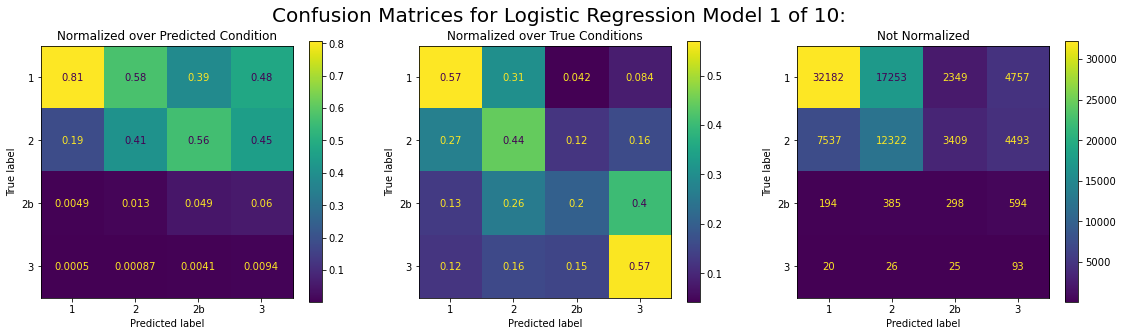

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.825852  0.507260  0.628487     56541
           2   0.409533  0.493354  0.447552     27761
          2b   0.039313  0.205303  0.065989      1471
           3   0.009223  0.567073  0.018152       164

    accuracy                       0.497713     85937
   macro avg   0.320980  0.443247  0.290045     85937
weighted avg   0.676343  0.497713  0.559245     85937



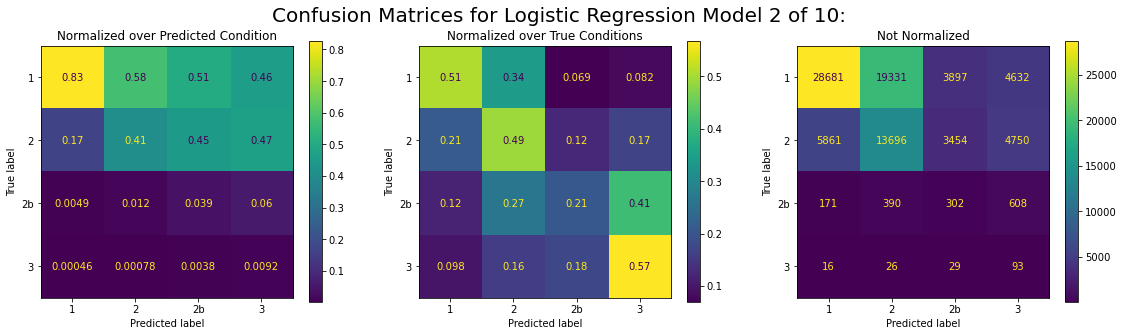

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.806830  0.567411  0.666265     56541
           2   0.422225  0.427974  0.425081     27761
          2b   0.036769  0.241332  0.063814      1471
           3   0.010024  0.512195  0.019663       164

    accuracy                       0.516681     85937
   macro avg   0.318962  0.437228  0.293706     85937
weighted avg   0.667886  0.516681  0.576807     85937



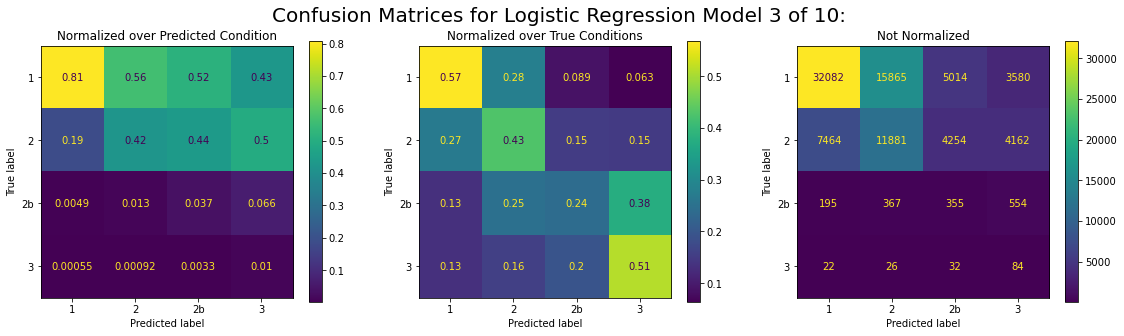

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.819036  0.545763  0.655041     56541
           2   0.420882  0.425309  0.423084     27761
          2b   0.032747  0.236574  0.057530      1471
           3   0.009915  0.579268  0.019497       164

    accuracy                       0.501623     85937
   macro avg   0.320645  0.446729  0.288788     85937
weighted avg   0.675414  0.501623  0.568669     85937



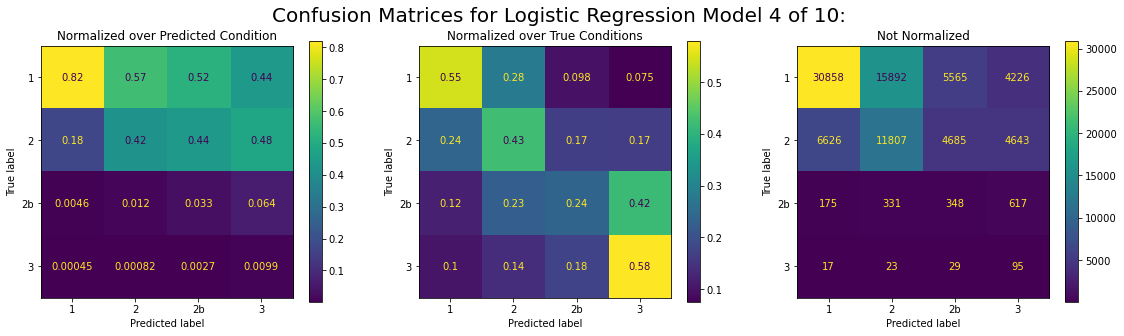

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.823779  0.532445  0.646821     56541
           2   0.416179  0.468499  0.440792     27761
          2b   0.041639  0.251530  0.071449      1471
           3   0.009616  0.542683  0.018898       164

    accuracy                       0.506999     85937
   macro avg   0.322803  0.448789  0.294490     85937
weighted avg   0.677166  0.506999  0.569219     85937



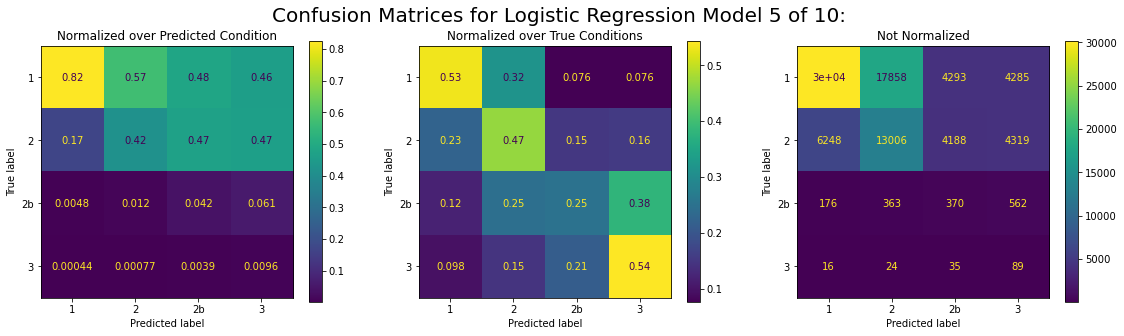

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.777408  0.657417  0.712395     56541
           2   0.428417  0.342459  0.380645     27761
          2b   0.050743  0.195105  0.080539      1471
           3   0.009245  0.579268  0.018199       164

    accuracy                       0.547610     85937
   macro avg   0.316453  0.443562  0.297945     85937
weighted avg   0.650766  0.547610  0.593087     85937



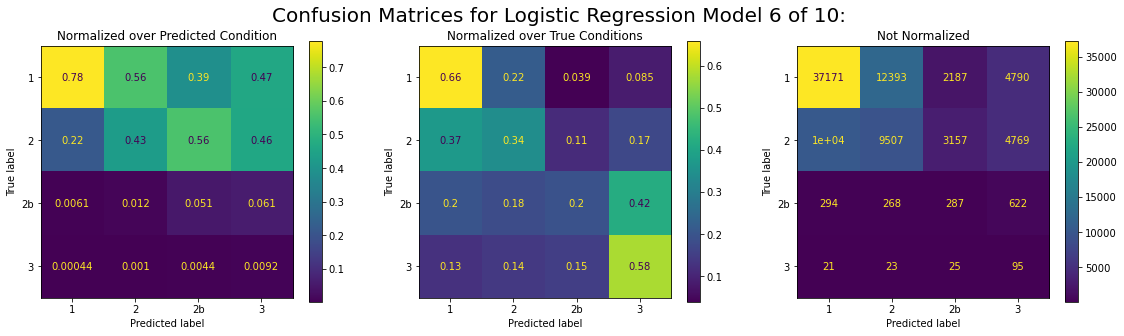

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.808456  0.570542  0.668975     56541
           2   0.412036  0.421743  0.416833     27761
          2b   0.042059  0.221618  0.070700      1471
           3   0.009525  0.573171  0.018738       164

    accuracy                       0.516506     85937
   macro avg   0.318019  0.446768  0.293812     85937
weighted avg   0.665753  0.516506  0.576042     85937



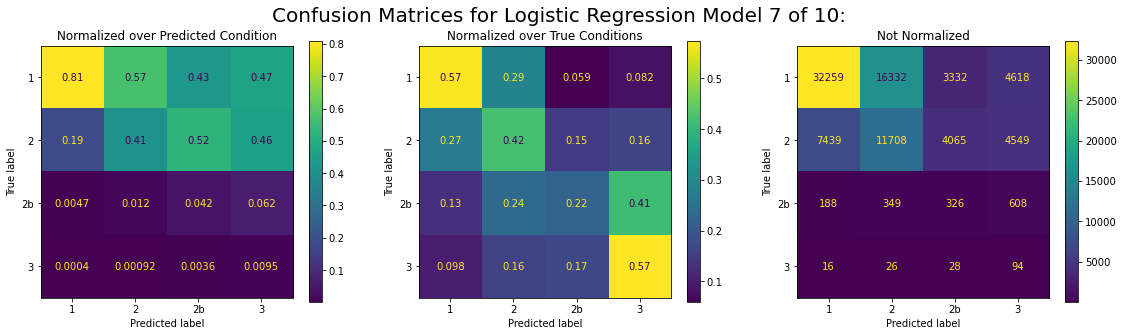

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.786159  0.609770  0.686820     56541
           2   0.433692  0.340802  0.381677     27761
          2b   0.033684  0.235214  0.058929      1471
           3   0.009205  0.560976  0.018112       164

    accuracy                       0.516378     85937
   macro avg   0.315685  0.436690  0.286384     85937
weighted avg   0.657936  0.516378  0.576223     85937



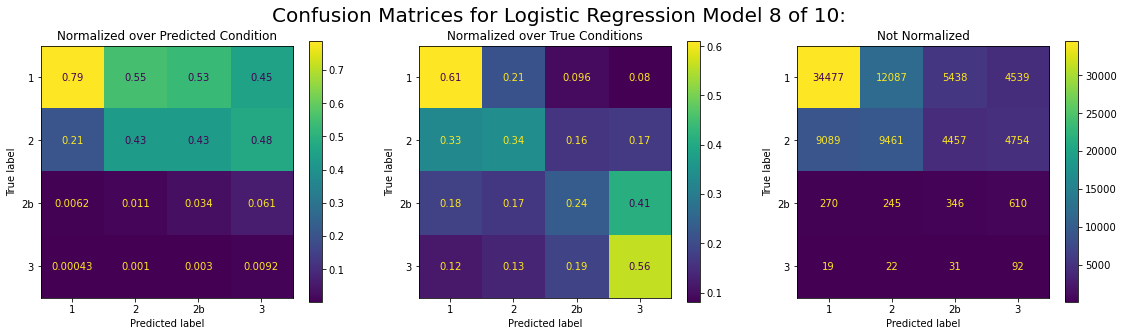

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.820296  0.527104  0.641801     56541
           2   0.412932  0.469976  0.439611     27761
          2b   0.038714  0.220938  0.065883      1471
           3   0.009569  0.560976  0.018818       164

    accuracy                       0.503473     85937
   macro avg   0.320378  0.444748  0.291528     85937
weighted avg   0.673776  0.503473  0.565439     85937



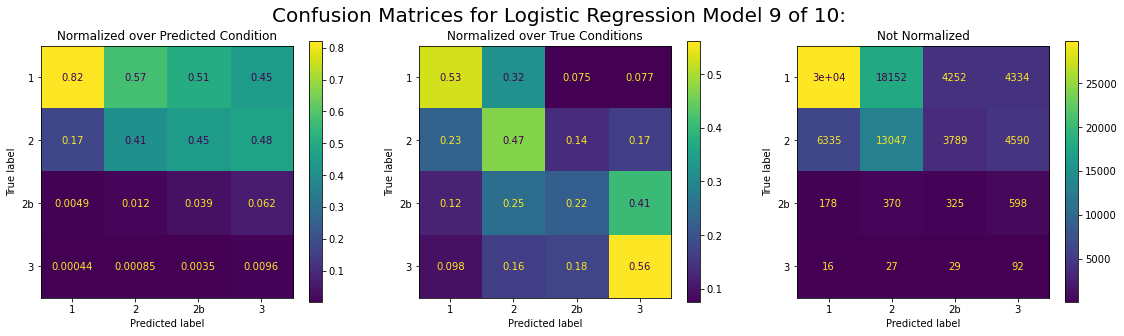

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.807629  0.588299  0.680733     56541
           2   0.422025  0.432621  0.427258     27761
          2b   0.044975  0.220258  0.074697      1471
           3   0.010012  0.554878  0.019669       164

    accuracy                       0.531645     85937
   macro avg   0.321160  0.449014  0.300589     85937
weighted avg   0.668487  0.531645  0.587215     85937



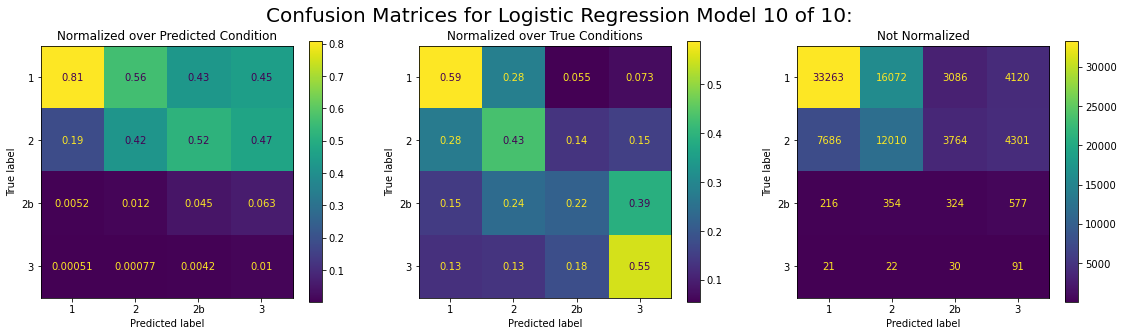

In [68]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [69]:
print_elapsed_time(notebook_start_time)

Elapsed time is 253.62452192103956 seconds.


In [70]:
# Report statistics of the models built for each fold of the cross-validation.
print('Support Vector Machine Cross-validation Scores:')
print()
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

Support Vector Machine Cross-validation Scores:

fit_time: mean = 0.096532, std = 0.036513
fit_time :[0.13420033 0.07095003 0.07815075 0.07024455 0.0681901  0.15853882
 0.15916467 0.08080578 0.08393979 0.06113958]

score_time: mean = 0.046443, std = 0.014806
score_time :[0.04781365 0.03917503 0.03425956 0.049119   0.08752465 0.04629493
 0.04919887 0.03657126 0.04037786 0.03409791]

test_f1_macro: mean = 0.441871, std = 0.019136
test_f1_macro :[0.41695207 0.42889936 0.44393107 0.470005   0.42293028 0.44122806
 0.47461398 0.44240893 0.42115752 0.4565809 ]

test_f1_weighted: mean = 0.441847, std = 0.019556
test_f1_weighted :[0.41695207 0.42889936 0.44526466 0.47095042 0.42256648 0.44077942
 0.4755283  0.44289059 0.41958722 0.4550469 ]

test_precision_macro: mean = 0.452593, std = 0.020658
test_precision_macro :[0.43133117 0.43960702 0.43968059 0.48409091 0.41752137 0.44679293
 0.47001734 0.45458981 0.4818315  0.46046484]

test_precision_weighted: mean = 0.452596, std = 0.020599
test_preci

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.815798  0.552537  0.658843     56541
           2   0.409206  0.461799  0.433914     27761
          2b   0.049845  0.208022  0.080420      1471
           3   0.009043  0.560976  0.017798       164

    accuracy                       0.517344     85937
   macro avg   0.320973  0.445833  0.297744     85937
weighted avg   0.669803  0.517344  0.575058     85937



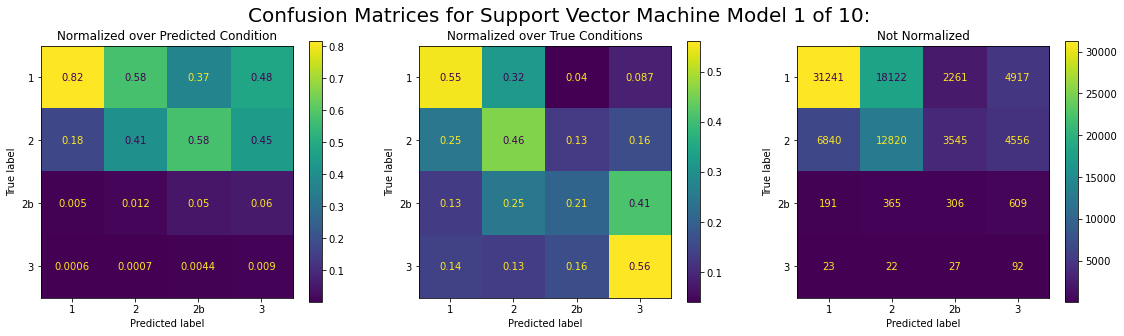

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.781062  0.606604  0.682867     56541
           2   0.415657  0.371997  0.392617     27761
          2b   0.044516  0.196465  0.072586      1471
           3   0.008327  0.542683  0.016403       164

    accuracy                       0.523674     85937
   macro avg   0.312391  0.429437  0.291118     85937
weighted avg   0.648940  0.523674  0.577386     85937



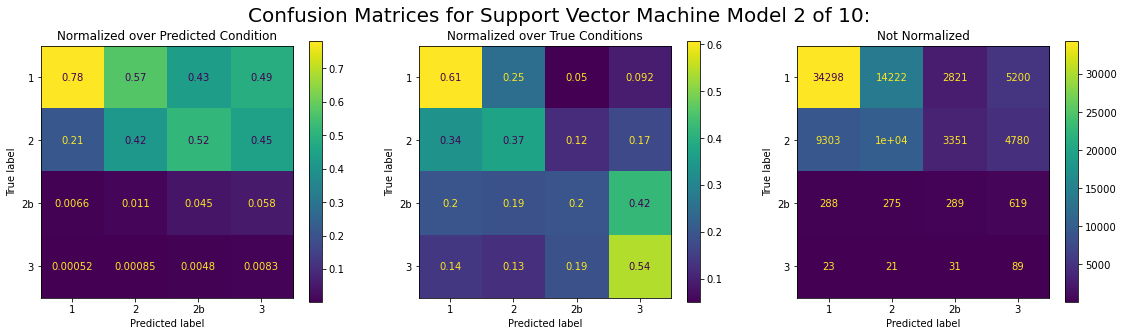

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.818094  0.537539  0.648785     56541
           2   0.418288  0.452974  0.434941     27761
          2b   0.037103  0.239973  0.064269      1471
           3   0.009447  0.530488  0.018564       164

    accuracy                       0.505114     85937
   macro avg   0.320733  0.440243  0.291640     85937
weighted avg   0.674029  0.505114  0.568497     85937



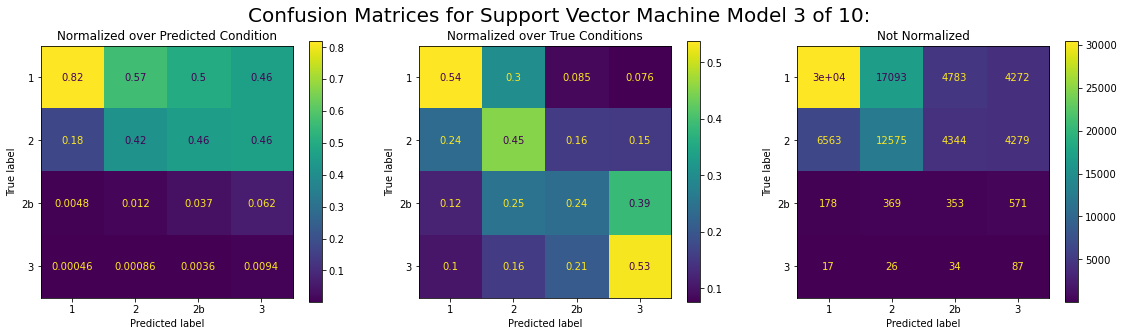

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.837508  0.513857  0.636926     56541
           2   0.417029  0.484132  0.448082     27761
          2b   0.037041  0.239973  0.064176      1471
           3   0.009275  0.536585  0.018235       164

    accuracy                       0.499610     85937
   macro avg   0.325213  0.443637  0.291855     85937
weighted avg   0.686395  0.499610  0.564937     85937



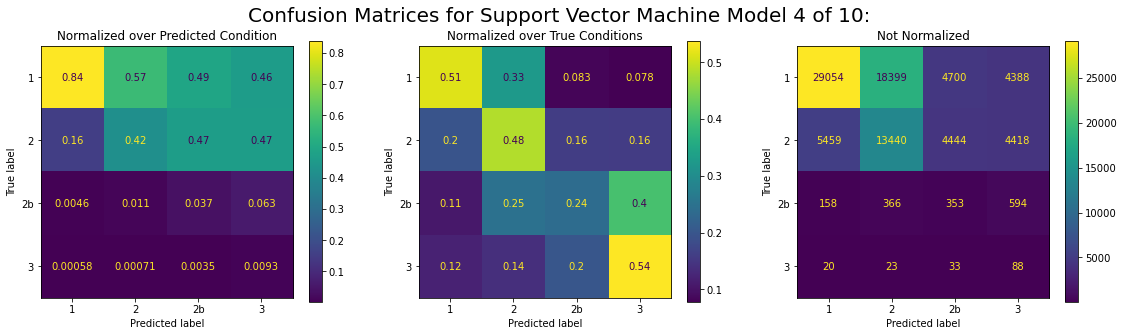

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.814046  0.551264  0.657366     56541
           2   0.416698  0.442996  0.429444     27761
          2b   0.042187  0.250170  0.072199      1471
           3   0.009137  0.524390  0.017962       164

    accuracy                       0.511084     85937
   macro avg   0.320517  0.442205  0.294243     85937
weighted avg   0.670939  0.511084  0.572502     85937



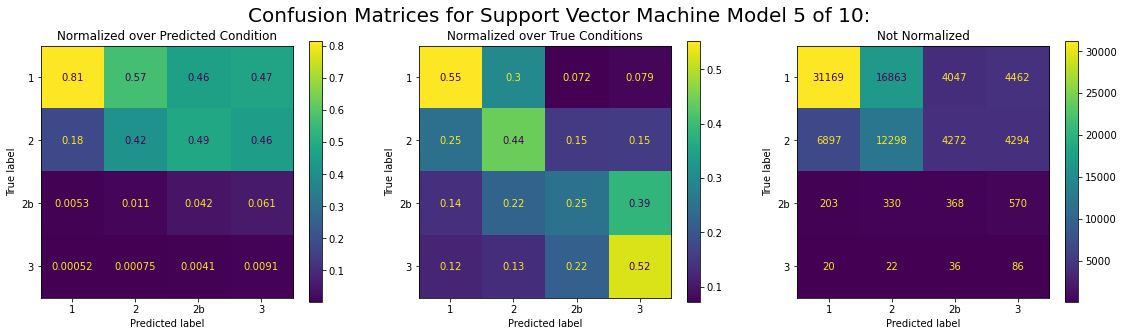

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.770719  0.678640  0.721755     56541
           2   0.430750  0.316379  0.364811     27761
          2b   0.054198  0.208022  0.085991      1471
           3   0.008898  0.548780  0.017511       164

    accuracy                       0.553312     85937
   macro avg   0.316141  0.437955  0.297517     85937
weighted avg   0.647177  0.553312  0.594221     85937



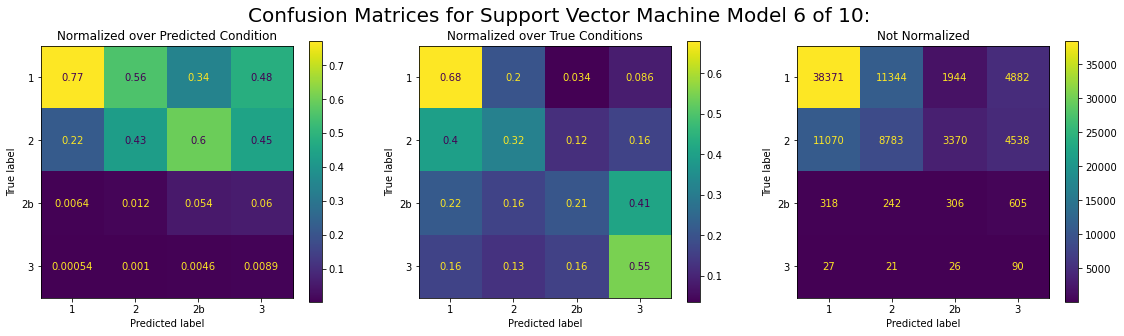

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.810419  0.552749  0.657231     56541
           2   0.414081  0.443212  0.428151     27761
          2b   0.041145  0.212101  0.068920      1471
           3   0.009230  0.567073  0.018164       164

    accuracy                       0.511561     85937
   macro avg   0.318719  0.443784  0.293117     85937
weighted avg   0.667690  0.511561  0.571940     85937



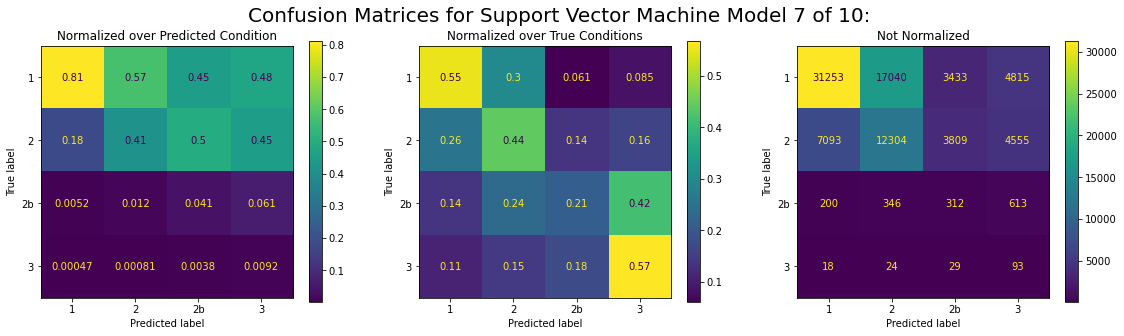

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.780783  0.644417  0.706076     56541
           2   0.430360  0.354166  0.388563     27761
          2b   0.049954  0.219579  0.081391      1471
           3   0.008836  0.536585  0.017386       164

    accuracy                       0.543177     85937
   macro avg   0.317483  0.438687  0.298354     85937
weighted avg   0.653599  0.543177  0.591500     85937



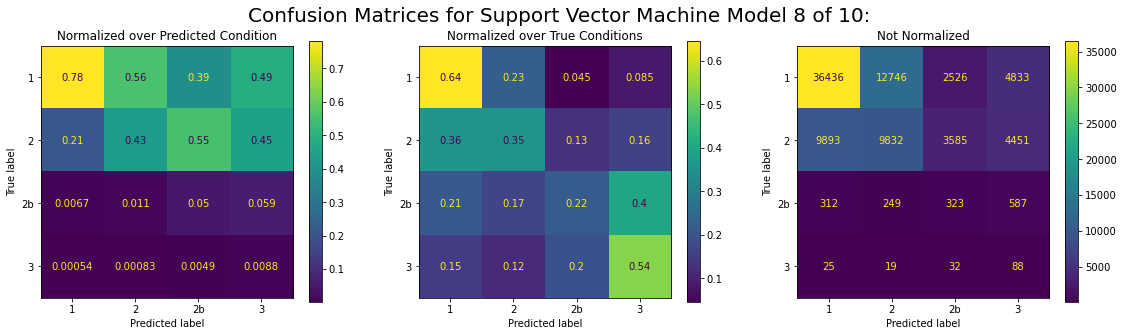

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.831816  0.512336  0.634109     56541
           2   0.412284  0.501495  0.452535     27761
          2b   0.043692  0.211421  0.072418      1471
           3   0.008801  0.548780  0.017324       164

    accuracy                       0.503753     85937
   macro avg   0.324148  0.443508  0.294097     85937
weighted avg   0.681230  0.503753  0.564662     85937



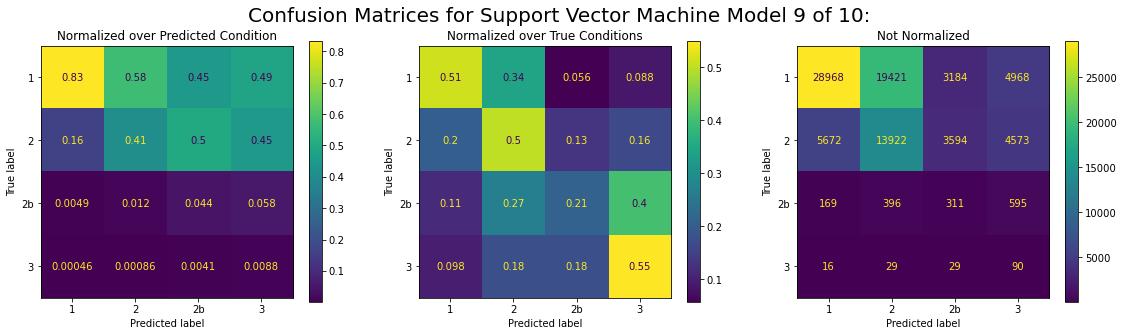

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.808803  0.587910  0.680889     56541
           2   0.422844  0.429668  0.426228     27761
          2b   0.047920  0.216179  0.078451      1471
           3   0.008906  0.542683  0.017525       164

    accuracy                       0.530342     85937
   macro avg   0.322118  0.444110  0.300773     85937
weighted avg   0.669573  0.530342  0.587046     85937



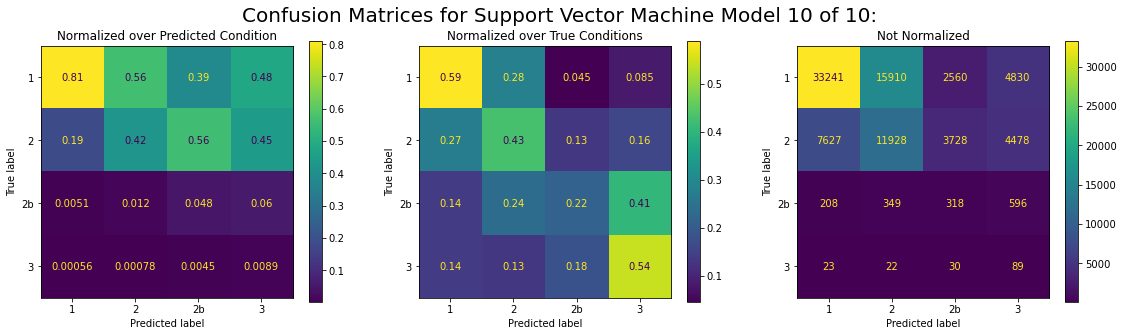

In [71]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [72]:
print_elapsed_time(notebook_start_time)

Elapsed time is 403.1949240670074 seconds.


In [73]:
# Report statistics of the models built for each fold of the cross-validation.
print('k-Nearest Neighbors Cross-validation Scores:')
print()
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

k-Nearest Neighbors Cross-validation Scores:

fit_time: mean = 0.022533, std = 0.005224
fit_time :[0.02861595 0.02095628 0.02238059 0.01519775 0.03125763 0.02035689
 0.01646948 0.01786757 0.02881026 0.023422  ]

score_time: mean = 0.191579, std = 0.043309
score_time :[0.15816712 0.17552066 0.22423387 0.14944386 0.28018212 0.25481677
 0.18790412 0.15821171 0.16213298 0.16517925]

test_f1_macro: mean = 0.446564, std = 0.022973
test_f1_macro :[0.41421517 0.42311794 0.47082355 0.46707965 0.44249375 0.48837799
 0.44283471 0.46073195 0.4288948  0.42706733]

test_f1_weighted: mean = 0.446679, std = 0.023385
test_f1_weighted :[0.41421517 0.42311794 0.4724012  0.46802109 0.44216383 0.48798635
 0.4433071  0.46166531 0.42791402 0.42599789]

test_neg_log_loss: mean = -3.401434, std = 0.572901
test_neg_log_loss :[-3.84903119 -4.06894033 -2.58134111 -4.01459737 -2.77712232 -3.0173934
 -2.77490385 -4.05130346 -3.78092125 -3.098789  ]

test_precision_macro: mean = 0.451896, std = 0.021250
test_precisi

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.745426  0.697529  0.720683     56541
           2   0.387179  0.278700  0.324104     27761
          2b   0.060982  0.163834  0.088881      1471
           3   0.007258  0.402439  0.014258       164

    accuracy                       0.552533     85937
   macro avg   0.300211  0.385626  0.286981     85937
weighted avg   0.616574  0.552533  0.580409     85937



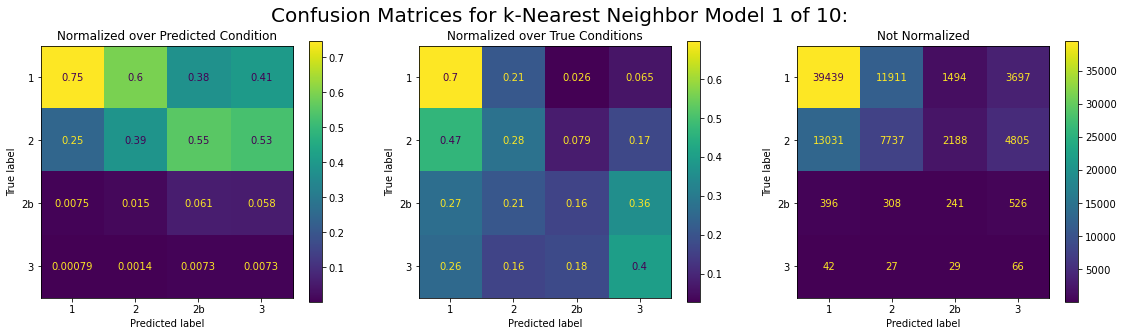

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.743657  0.686864  0.714133     56541
           2   0.377794  0.280069  0.321673     27761
          2b   0.066235  0.299116  0.108455      1471
           3   0.006162  0.243902  0.012021       164

    accuracy                       0.547971     85937
   macro avg   0.298462  0.377488  0.289071     85937
weighted avg   0.612466  0.547971  0.575646     85937



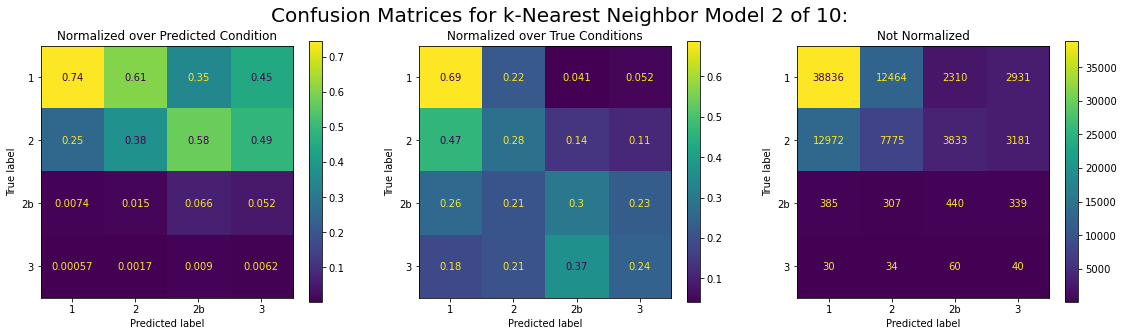

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.772879  0.602395  0.677070     56541
           2   0.403078  0.268902  0.322595     27761
          2b   0.024322  0.229096  0.043975      1471
           3   0.006743  0.390244  0.013256       164

    accuracy                       0.487869     85937
   macro avg   0.301755  0.372659  0.264224     85937
weighted avg   0.639143  0.487869  0.550457     85937



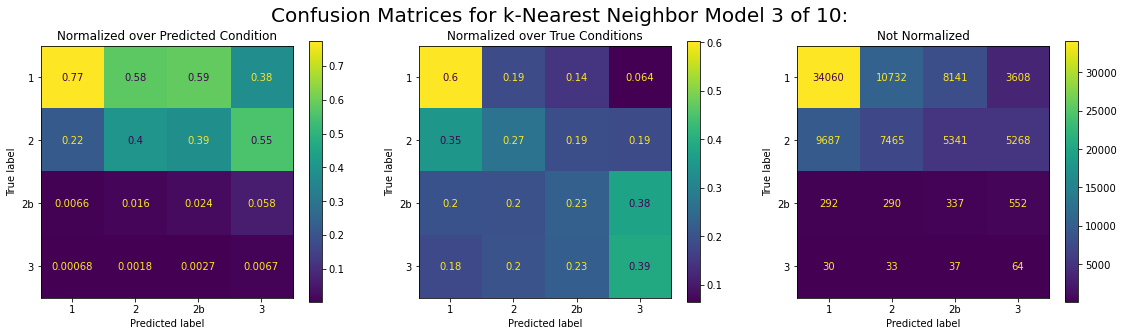

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.769871  0.609009  0.680057     56541
           2   0.407949  0.246245  0.307112     27761
          2b   0.027152  0.316111  0.050008      1471
           3   0.008052  0.359756  0.015752       164

    accuracy                       0.486333     85937
   macro avg   0.303256  0.382780  0.263232     85937
weighted avg   0.638789  0.486333  0.547529     85937



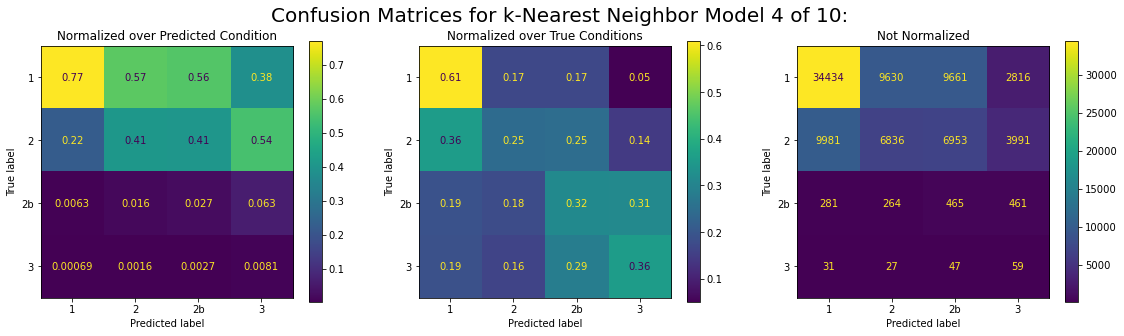

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.780679  0.590138  0.672166     56541
           2   0.407559  0.452145  0.428696     27761
          2b   0.040698  0.147519  0.063795      1471
           3   0.008491  0.365854  0.016598       164

    accuracy                       0.537557     85937
   macro avg   0.309357  0.388914  0.295314     85937
weighted avg   0.646007  0.537557  0.581851     85937



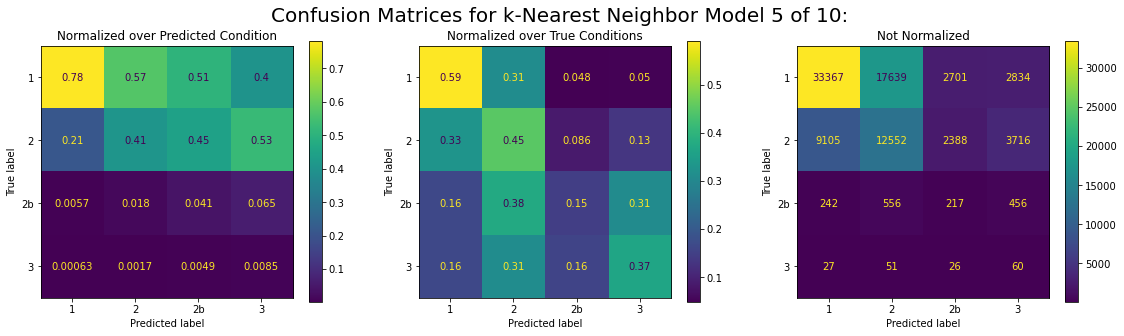

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.795674  0.580322  0.671146     56541
           2   0.404541  0.403083  0.403811     27761
          2b   0.050142  0.288239  0.085424      1471
           3   0.006176  0.323171  0.012120       164

    accuracy                       0.517577     85937
   macro avg   0.314133  0.398704  0.293125     85937
weighted avg   0.655055  0.517577  0.573503     85937



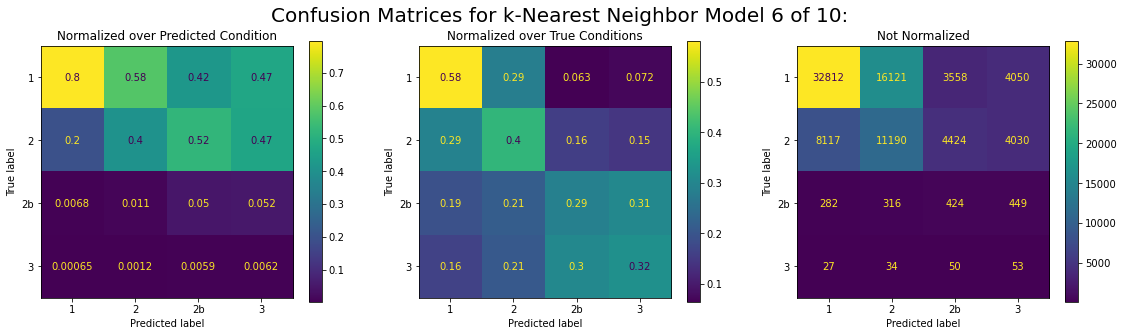

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.788584  0.585221  0.671851     56541
           2   0.395865  0.440726  0.417093     27761
          2b   0.049247  0.155676  0.074824      1471
           3   0.007720  0.396341  0.015144       164

    accuracy                       0.530831     85937
   macro avg   0.310354  0.394491  0.294728     85937
weighted avg   0.647575  0.530831  0.578082     85937



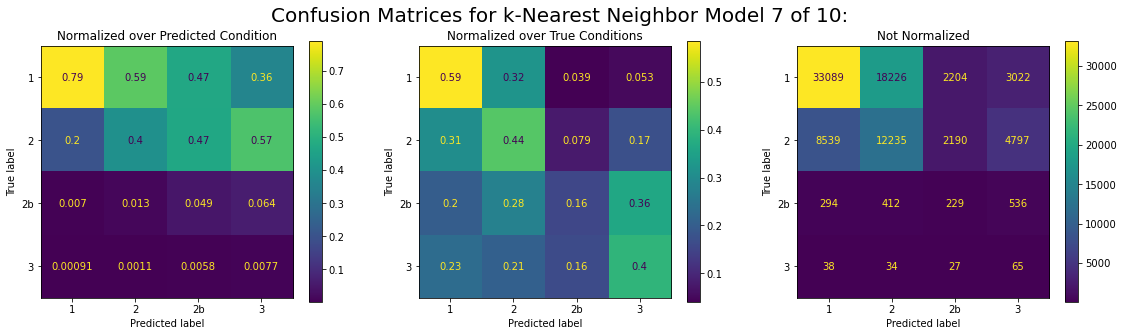

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.787423  0.561646  0.655642     56541
           2   0.386156  0.439682  0.411184     27761
          2b   0.054588  0.255608  0.089963      1471
           3   0.008156  0.353659  0.015945       164

    accuracy                       0.516611     85937
   macro avg   0.309081  0.402649  0.293183     85937
weighted avg   0.643767  0.516611  0.565769     85937



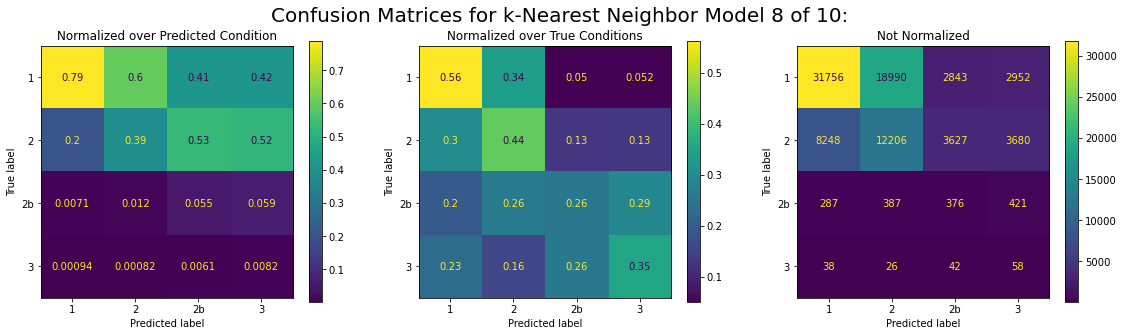

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.772230  0.589501  0.668606     56541
           2   0.389742  0.393898  0.391809     27761
          2b   0.054398  0.264446  0.090234      1471
           3   0.007004  0.323171  0.013711       164

    accuracy                       0.520242     85937
   macro avg   0.305844  0.392754  0.291090     85937
weighted avg   0.634924  0.520242  0.568040     85937



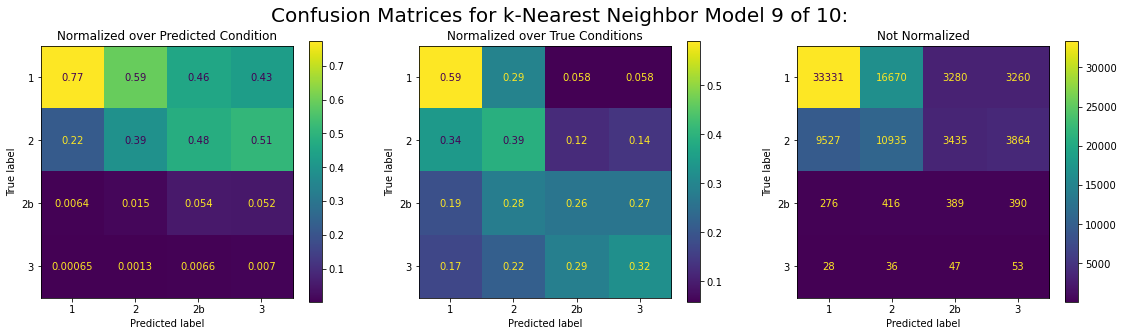

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.763994  0.657328  0.706659     56541
           2   0.393331  0.351392  0.371181     27761
          2b   0.060061  0.254249  0.097168      1471
           3   0.006388  0.243902  0.012449       164

    accuracy                       0.550810     85937
   macro avg   0.305943  0.376718  0.296864     85937
weighted avg   0.630760  0.550810  0.586529     85937



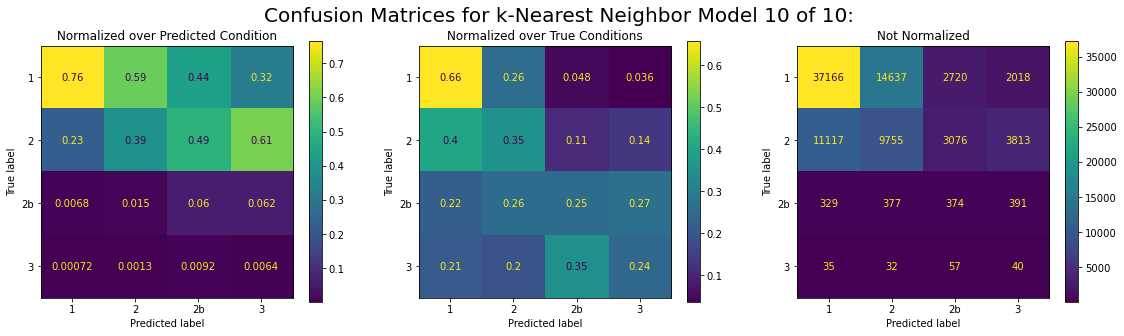

In [74]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [75]:
print('All reports and graphics generated in %f seconds.' % (elapsed_time(t0)))

All reports and graphics generated in 1323.613103 seconds.


In [76]:
print_elapsed_time(notebook_start_time)

Elapsed time is 1429.1831059289398 seconds.
